# Basics II

**Check the following line. Why there is no GPU?**

In [13]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [14]:
# Get the current device
current_device = qibo.get_device()
print(f"Current device: {current_device}")

Current device: /GPU:0


In [2]:
import qibo

# Get the current backend
current_backend = qibo.get_backend()
print(f"Current backend: {current_backend}")

# Get the current device
current_device = qibo.get_device()
print(f"Current device: {current_device}")

[Qibo 0.2.1|INFO|2023-10-24 22:30:25]: Using tensorflow backend on /device:CPU:0


Current backend: tensorflow
Current device: /device:CPU:0


In [4]:
from qibo.models import QFT

qibo.set_backend("tensorflow")
qibo.set_device("/CPU:0")

c = QFT(20)
final_state = c() # circuit will now be executed on CPU
print()
print(final_state)

[Qibo 0.2.1|INFO|2023-10-24 22:30:47]: Using tensorflow backend on /CPU:0
[Qibo 0.2.1|INFO|2023-10-24 22:30:47]: Using tensorflow backend on /CPU:0



(0.00098+0j)|00000000000000000000> + (0.00098+0j)|00000000000000000001> + (0.00098+0j)|00000000000000000010> + (0.00098+0j)|00000000000000000011> + (0.00098+0j)|00000000000000000100> + (0.00098+0j)|00000000000000000101> + (0.00098+0j)|00000000000000000110> + (0.00098+0j)|00000000000000000111> + (0.00098+0j)|00000000000000001000> + (0.00098+0j)|00000000000000001001> + (0.00098+0j)|00000000000000001010> + (0.00098+0j)|00000000000000001011> + (0.00098+0j)|00000000000000001100> + (0.00098+0j)|00000000000000001101> + (0.00098+0j)|00000000000000001110> + (0.00098+0j)|00000000000000001111> + (0.00098+0j)|00000000000000010000> + (0.00098+0j)|00000000000000010001> + (0.00098+0j)|00000000000000010010> + (0.00098+0j)|00000000000000010011> + ...


In [10]:
from qibo import Circuit, gates
qibo.set_device("/CPU:0")

# Construct the circuit
c = QFT(25)
for i in range(25):
    c.add(gates.H(i))

final_state = c() # circuit will now be executed on CPU
print()
print(final_state)

[Qibo 0.2.1|INFO|2023-10-24 22:50:41]: Using tensorflow backend on /CPU:0



(1+0j)|0000000000000000000000000>


In [16]:
import numpy as np
import qibo
from qibo import Circuit, gates

qibo.set_device("/GPU:5")

# Construct the circuit
c = QFT(25)
for i in range(25):
    c.add(gates.H(i))

final_state = c() # circuit will now be executed on GPU
print()
print(final_state)

[Qibo 0.2.1|INFO|2023-10-25 00:54:56]: Using tensorflow backend on /GPU:5



(1+0j)|0000000000000000000000000>


## Restart Kernet for setting the number of CPU threads

Un "thread" (o hilo en español) es una secuencia de instrucciones que pueden ser ejecutadas en paralelo con otras secuencias en un programa. En un sistema operativo, los threads son una forma de permitir que múltiples operaciones ocurran simultáneamente dentro de un mismo proceso.

**From here, everything has turned very incomprehensible!**

In [1]:
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
# Explore more on this!!

import qibo
from qibo.models import Circuit


qibo.set_device("/CPU:0")

# accelerators = {"/GPU:0": 3, "/GPU:1": 1}

c = Circuit(2)#, accelerators)
final_state = c() # circuit will now be executed on CPU
print(final_state)

[Qibo 0.2.1|INFO|2023-10-25 17:23:02]: Using tensorflow backend on /device:CPU:0
[Qibo 0.2.1|INFO|2023-10-25 17:23:02]: Using tensorflow backend on /CPU:0


(1+0j)|00>


In [4]:
# set the number of threads to 1
qibo.set_threads(1)
# retrieve the current number of threads
current_threads = qibo.get_threads()

[Qibo 0.2.1|WARNING|2023-10-24 20:37:35]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


In [17]:
# import qibo
# import numpy as np

# qibo.set_backend("numpy")

# from qibo import Circuit, gates

# qibo.set_device("/CPU:0")

accelerators = {"/GPU:0": 3, "/GPU:1": 1}

c = Circuit(5, accelerators)


c.add(gates.X(0))
c.add(gates.X(1))
c.add(gates.CU1(0, 1, 0.1234))


init_state = np.ones(4) / 2.0
c(init_state)

[Qibo 0.2.1|ERROR|2023-10-25 01:23:32]: tensorflow does not support distributed execution.


NotImplementedError: tensorflow does not support distributed execution.

**Up to here, everything has been very confusing!**

## Callbacks for entanglement entropy

An example use case of this is the calculation of entanglement entropy as the state propagates through a circuit. This can be implemented easily using `qibo.callbacks.EntanglementEntropy` and the `qibo.gates.CallbackGate` gate.

In [31]:
from qibo import models, gates, callbacks

# create entropy callback where qubit 0 is the first subsystem
entropy = callbacks.EntanglementEntropy([0])

# initialize circuit with 2 qubits and add gates
c = models.Circuit(2) # state is |00> (entropy = 0)
c.add(gates.CallbackGate(entropy)) # performs entropy calculation in the initial state
c.add(gates.H(0)) # state is |+0> (entropy = 0)
c.add(gates.CallbackGate(entropy)) # performs entropy calculation after H
c.add(gates.CNOT(0, 1)) # state is |00> + |11> (entropy = 1))
c.add(gates.CallbackGate(entropy)) # performs entropy calculation after CNOT

# Execute the circuit using the callback
final_state = c()

# Draw the circuit:
print('Given this circuit:')
print(c.draw())

# tf to float:
formatted_output = [format(tensor.numpy(), '.3f') for tensor in entropy[:]]
print('\nEntropy calculation is performed after c() is executed:\n', formatted_output)
print('This is the entropy of the Bell state! :D\n')

# Prints the final state in Dirac form:
print('Final state:', final_state)

# Execute the circuit a second time
final_state = c()
formatted_output_2 = [format(tensor.numpy(), '.3f') for tensor in entropy[:]]
print('\nEntropy calculation when cicuit is executed for second time:\n', formatted_output_2)

Given this circuit:
q0: ─EE─H─EE─o─EE─
q1: ─EE───EE─X─EE─

Entropy calculation is performed after c() is executed:
 ['-0.000', '0.000', '1.000']
This is the entropy of the Bell state! :D

Final state: (0.70711+0j)|00> + (0.70711+0j)|11>

Entropy calculation when cicuit is executed for second time:
 ['-0.000', '0.000', '1.000', '-0.000', '0.000', '1.000']


The final state is the following Bell state:

$$|\Phi^+\rangle=\frac{|00\rangle+|11\rangle}{\sqrt{2}}$$

In [33]:
import numpy as np
1/np.sqrt(2)

0.7071067811865475

## Parametrized gates

Qibo gates such as rotations accept values for their free parameter. Once such gates are added in a circuit their parameters can be updated using the `qibo.models.circuit.Circuit.set_parameters()` method.

In [36]:
from qibo import Circuit, gates
# create a circuit with all parameters set to 0.
c = Circuit(3)

# All rotation angles are parametric and can be changed later
c.add(gates.RX(0, theta=0))
c.add(gates.RY(1, theta=0))
c.add(gates.CZ(1, 2))
c.add(gates.fSim(0, 2, theta=0, phi=0))
c.add(gates.H(2))

# Draw the circuit:
print('Given this circuit:')
print(c.draw())

# Prints the final state in Dirac form:
final_state = c()
print('\nFinal state:', final_state)

# set new values to the circuit's parameters
params = [0.123, 0.456, (0.789, 0.321)]
c.set_parameters(params)

# Prints the final state after changing parameters:
final_state = c()
print('\nFinal state:', final_state)


Given this circuit:
q0: ─RX───f───
q1: ─RY─o─|───
q2: ────Z─f─H─

Final state: (0.70711+0j)|000> + (0.70711+0j)|001>

Final state: (0.65746+0j)|000> + (0.71755+0j)|001> + (0.15255+0j)|010> + (0.1665+0j)|011> + -0.02983j|100> + -0.02983j|101> + -0.00692j|110> + -0.00692j|111>


Equivalently, set parameters `circuit.set_parameters()` with a dictionary or a flat list.

In [ ]:
c = Circuit(3)
g0 = gates.RX(0, theta=0)
g1 = gates.RY(1, theta=0)
g2 = gates.fSim(0, 2, theta=0, phi=0)
c.add([g0, g1, gates.CZ(1, 2), g2, gates.H(2)])

# set new values to the circuit's parameters using a dictionary
params = {g0: 0.123, g1: 0.456, g2: (0.789, 0.321)}
c.set_parameters(params)
# equivalently the parameter's can be update with a list as
params = [0.123, 0.456, (0.789, 0.321)]
c.set_parameters(params)
# or with a flat list as
params = [0.123, 0.456, 0.789, 0.321]
c.set_parameters(params)

The following gates support parameter setting:

* `RX`, `RY`, `RZ`, `U1`, `CU1`: Accept a single `theta` parameter.

* `qibo.gates.fSim`: Accepts a tuple of two parameters (`theta`, `phi`).

* `qibo.gates.GeneralizedfSim`: Accepts a tuple of two parameters `(unitary, phi)`. Here `unitary` should be a unitary matrix given as an array or `tf.Tensor` of shape `(2, 2)`.

* `qibo.gates.Unitary`: Accepts a single `unitary` parameter. This should be an array or `tf.Tensor` of shape `(2, 2)`.

**Note** that a `np.ndarray` or a `tf.Tensor` may also be used in the place of a flat list. Using `qibo.models.circuit.Circuit.set_parameters()` is more efficient than recreating a new circuit with new parameter values.

**Get parameters:** The inverse method `qibo.models.circuit.Circuit.get_parameters()` is also available and returns a list, dictionary or flat list.

Hide a parametrized gate from the action of `qibo.models.circuit.Circuit.get_parameters()` and `qibo.models.circuit.Circuit.set_parameters()`` by setting the `trainable=False` during gate creation.

In [42]:
c = Circuit(3)
c.add(gates.RX(0, theta=0.123))
c.add(gates.RY(1, theta=0.456, trainable=True))
c.add(gates.fSim(0, 2, theta=0.789, phi=0.567))

print(c.get_parameters())
# prints [(0.123,), (0.789, 0.567)] ignoring the parameters of the RY gate

[(0.123,), (0.456,), (0.789, 0.567)]


This is useful when the user wants to freeze the parameters of specific gates during optimization.

## Collapse state during measurements

Collapse the state during measurements and re-use measured qubits in the circuit.

During instantiation of the `qibo.gates.M` gate.

In [24]:
from qibo import Circuit, gates

c = Circuit(1)
c.add(gates.H(0))
output = c.add(gates.M(0, collapse=True))
c.add(gates.H(0))

result = c(nshots=5)
print(result)
print()
print(c.draw())
# prints [0.7071, 0.7071] if 0 is measured
# or [0.7071, -0.7071] if 1 is measured

[<tf.Tensor: shape=(2,), dtype=complex128, numpy=array([0.70710678+0.j, 0.70710678+0.j])>, <tf.Tensor: shape=(2,), dtype=complex128, numpy=array([0.70710678+0.j, 0.70710678+0.j])>, <tf.Tensor: shape=(2,), dtype=complex128, numpy=array([0.70710678+0.j, 0.70710678+0.j])>, <tf.Tensor: shape=(2,), dtype=complex128, numpy=array([ 0.70710678+0.j, -0.70710678+0.j])>, <tf.Tensor: shape=(2,), dtype=complex128, numpy=array([ 0.70710678+0.j, -0.70710678+0.j])>]

q0: ─H─M─H─


In [25]:
print(output.frequencies(binary=True))
print(output.samples(binary=False))
print(output.samples(binary=True))

Counter({'0': 3, '1': 2})
tf.Tensor([0 0 0 1 1], shape=(5,), dtype=int32)
[[0]
 [0]
 [0]
 [1]
 [1]]


Using normal measurements and collapse measurements in the same circuit:

In [10]:
from qibo import Circuit, gates

c = Circuit(2)
c.add(gates.H(0))
c.add(gates.H(1))
output = c.add(gates.M(0, collapse=True))
c.add(gates.H(0))
c.add(gates.M(0, 1))
result = c(nshots=5)

print(c.draw())
print()
print(result)

q0: ─H─M─H─M─
q1: ─H─────M─

(0.5+0j)|00> + (0.5+0j)|01> + (0.5+0j)|10> + (0.5+0j)|11>


**Circuit:**

$|0\rangle$ ----H $\tiny|+\rangle$ ----M $\tiny|0\rangle\ |\ |1\rangle$ ----H $\tiny|+\rangle\ |\ |-\rangle$ ----M $\tiny|0\rangle\ |\ |1\rangle$

$|0\rangle$ ----H $\tiny|+\rangle$ -----------------------------M $\tiny|0\rangle\ |\ |1\rangle$

In [11]:
print(output.samples(binary=True))
print(result.samples(binary=True))

[[1]
 [1]
 [1]
 [0]
 [0]]
tf.Tensor(
[[0 1]
 [1 0]
 [1 0]
 [1 1]
 [0 1]], shape=(5, 2), dtype=int32)


In [12]:
print(result.frequencies(binary=True))
print(result.frequencies(binary=True))

Counter({1: 2, 10: 2, 11: 1})
Counter({1: 2, 10: 2, 11: 1})


**The output is wired... The keys are not strings...**

Then 01 is shown as 1.

In [13]:
print(output.frequencies(binary=True, registers=True))
print(output.frequencies(binary=False, registers=True))

Counter({'1': 3, '0': 2})
Counter({1: 3, 0: 2})


### Conditioning gates on measurement outcomes

The output of `collapse=True` measurements can be used as a parameter in any parametrized gate.

In [58]:
import numpy as np
from qibo import Circuit, gates

c = Circuit(2)
c.add(gates.H(0))
output = c.add(gates.M(0, collapse=True))
c.add(gates.RX(1, theta=np.pi * output.symbols[0] / 4))
result = c()

print('If the mesurement gives |0>, everything is in the fundamental state.')
print()
print('If the mesurement gives |1>, apply this rotation to q2:\n   cos:', np.cos(np.pi / 8), '\n   sin: -i*', np.sin(np.pi / 8))
print()
print(c.draw())
print()
print(result)

If the mesurement gives |0>, everything is in the fundamental state.

If the mesurement gives |1>, apply this rotation to q2:
   cos: 0.9238795325112867 
   sin: -i* 0.3826834323650898

q0: ─H──M─
q1: ─RX───

[<tf.Tensor: shape=(4,), dtype=complex128, numpy=array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])>]


The circuit drew is wired, as the mesurment defines the Rx gate. I imagine something like:

**Circuit:**

$|0\rangle$ ----H $\tiny|+\rangle$ ---- M $\tiny\text{out = }|0\rangle\ |\ |1\rangle$ --------

$|0\rangle$ ---------------- Rx $\footnotesize(\theta=\pi*\text{out})$ $\tiny|0\rangle\ |\ |1\rangle$

### More than one qubits used in a collapsed measurement gate

Execute the code and note that if:

* the 2 measurements gives |0> no rotation is obtained, Rx = Ry = I.

    All qubits in the fundamental state; i.e. (10000000)

* M(0) = |1> and M(1) = |0>

In [93]:
c = Circuit(3)
c.add(gates.H(0))
output = c.add(gates.M(0, 1, collapse=True))
c.add(gates.RX(1, theta=np.pi * output.symbols[0] / 4))
c.add(gates.RY(2, theta=np.pi * (output.symbols[0] + output.symbols[1]) / 5))
result = c()

print(c.draw())
print()
print(result)
print()
print('If the 2 mesurements gives |0>, everything is in the fundamental state.')
print()
print(f'''If M0 = |0> and M1 gives |1>, apply this rotation to q2:\n   cos: {np.cos(np.pi / 10)}\n   sin: {np.sin(np.pi / 8)}''')
print()


q0: ─H─M────
q1: ───M─RX─
q2: ─────RY─

[<tf.Tensor: shape=(8,), dtype=complex128, numpy=
array([0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.87866165+0.j        , 0.28549448+0.j        ,
       0.        -0.36395357j, 0.        -0.11825568j])>]

If the 2 mesurements gives |0>, everything is in the fundamental state.

If M0 = |0> and M1 gives |1>, apply this rotation to q2:
   cos: 0.9510565162951535
   sin: 0.3826834323650898



In [39]:
print(output.symbols[0] + output.symbols[1])

m35 + m36


## Invert a circuit

Taking the **dagger** of all gates in reverse order.

reminiscent of a "quantum echo": error mitigation technique (errors or noise introduced during the initial operations can be "undone" or mitigated)

$$(Rx,Cz)CU2(Rx,Cz)^T$$

single-qubit rotations followed by two-qubit gates


In [105]:
from qibo import Circuit, gates

# Create a subroutine
subroutine = Circuit(6)
subroutine.add([gates.RX(i, theta=0.1) for i in range(5)])
subroutine.add([gates.CZ(i, i + 1) for i in range(0, 5, 2)])
print()

# Create the middle part of the circuit
middle = Circuit(6)
middle.add([gates.CU2(i, i + 1, phi=0.1, lam=0.2) for i in range(0, 5, 2)])

# Create the total circuit as subroutine + middle + subroutine^{-1}
circuit = subroutine + middle + subroutine.invert()

print(circuit.draw())


q0: ─RX─o─────o────────────o─RX─
q1: ─RX─Z─────U2───────────Z─RX─
q2: ─RX───o──────o───────o───RX─
q3: ─RX───Z──────U2──────Z───RX─
q4: ─RX─────o───────o──o─────RX─
q5: ────────Z───────U2─Z────────


## Embedded circuits

(Rx-CNOT)x2-even * QFT-odd  * (QFT)T-on6 

[embedded] * [Shor's factoring algorithm] * [transform back to computational basis]

In [111]:
from qibo import models, gates

# Create a small circuit of 4 qubits
smallc = models.Circuit(4)
smallc.add((gates.RX(i, theta=0.1) for i in range(4)))
smallc.add((gates.CNOT(0, 1), gates.CNOT(2, 3)))
print(smallc.draw())
print()

# Create a large circuit on 8 qubits
largec = models.Circuit(8)
# Add the small circuit on even qubits
largec.add(smallc.on_qubits(*range(0, 8, 2)))
# Add a QFT on odd qubits
largec.add(models.QFT(4).on_qubits(*range(1, 8, 2)))
# Add an inverse QFT on first 6 qubits
largec.add(models.QFT(6).invert().on_qubits(*range(6)))
print(largec.draw())

q0: ─RX─o───
q1: ─RX─X───
q2: ─RX───o─
q3: ─RX───X─

q0:     ─RX─o─────────────────────────────────────x─────────────────────────── ...
q1:     ────|───H─U1─U1─U1────────────────x─────x─|─────────────────────────── ...
q2:     ─RX─X─────|──|──|─────────────────|───x─|─|────────────────U1─U1─U1─H─ ...
q3:     ──────────o──|──|──H─U1─U1────────|─x─x─|─|────────U1─U1─H─|──|──o──── ...
q4:     ─RX───o──────|──|────|──|─────────|─|───x─|───U1─H─|──o────|──o─────── ...
q5:     ──────|──────o──|────o──|──H─U1───|─x─────x─H─o────o───────o────────── ...
q6:     ─RX───X─────────|───────|────|────|─────────────────────────────────── ...
q7:     ────────────────o───────o────o──H─x─────────────────────────────────── ...

q0: ... ──────────────U1─U1─U1─U1─U1─H─
q1: ... U1─U1─U1─U1─H─|──|──|──|──o────
q2: ... |──|──|──o────|──|──|──o───────
q3: ... |──|──o───────|──|──o──────────
q4: ... |──o──────────|──o─────────────
q5: ... o─────────────o────────────────
q6: ... ───────────────────────────────
q7

#  Variational Quantum Eigensolver (VQE) 

Find ground state

VQE consist on, 

1) Hamiltonian (expressed as a sum of Pauli terms)
2) Variational form parameterized as a circuit.

Then, $\langle\Psi|H|\Psi\rangle=E_{ansatz}$

In [2]:
import numpy as np
from qibo import models, gates, hamiltonians

nqubits = 6
nlayers  = 4

# Create variational circuit
circuit = models.Circuit(nqubits)
for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))

# Create XXZ Hamiltonian
hamiltonian = hamiltonians.XXZ(nqubits=nqubits)
# Create VQE model
vqe = models.VQE(circuit, hamiltonian)

# Optimize starting from a random guess for the variational parameters
initial_parameters = np.random.uniform(0, 2*np.pi,
                                        2*nqubits*nlayers + nqubits)
best, params, extra = vqe.minimize(initial_parameters, method='BFGS', compile=False)

### Circuit exploration

In [17]:
print(circuit.draw())
print('\nCircuit characterization:')
print(circuit.summary())

q0:     ─RY─o─────RY─────o─RY─o─────RY─────o─RY─o─────RY─────o─RY─o─────RY──── ...
q1:     ─RY─Z─────RY─o───|─RY─Z─────RY─o───|─RY─Z─────RY─o───|─RY─Z─────RY─o── ...
q2:     ─RY───o───RY─Z───|─RY───o───RY─Z───|─RY───o───RY─Z───|─RY───o───RY─Z── ...
q3:     ─RY───Z───RY───o─|─RY───Z───RY───o─|─RY───Z───RY───o─|─RY───Z───RY───o ...
q4:     ─RY─────o─RY───Z─|─RY─────o─RY───Z─|─RY─────o─RY───Z─|─RY─────o─RY───Z ...
q5:     ─RY─────Z─RY─────Z─RY─────Z─RY─────Z─RY─────Z─RY─────Z─RY─────Z─RY──── ...

q0: ... ─o─RY─
q1: ... ─|─RY─
q2: ... ─|─RY─
q3: ... ─|─RY─
q4: ... ─|─RY─
q5: ... ─Z─RY─

Circuit characterization:
Circuit depth = 17
Total number of gates = 78
Number of qubits = 6
Most common gates:
ry: 54
cz: 24


### Explore initial/final parameters

We have 2 * `nqubits` * `nlayers` + `nqubits` = 54 rotations (parameters)

Plot the 54 initial parameters.


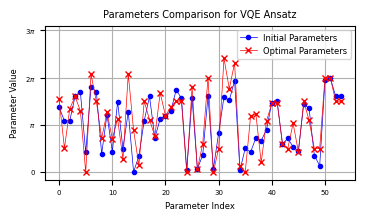

In [45]:
import matplotlib.pyplot as plt

# Visualization
print(f'Plot the {len(initial_parameters)} initial parameters.')
plt.figure(figsize=(4,2))
plt.plot(initial_parameters, marker='o', linestyle='-', markersize=3, color='blue', label='Initial Parameters', lw=0.5)
plt.plot(params, marker='x', linestyle='-', markersize=4, color='red', label='Optimal Parameters', lw=0.5)

plt.xlabel('Parameter Index', fontsize=6)
plt.ylabel('Parameter Value', fontsize=6)
plt.title('Parameters Comparison for VQE Ansatz', fontsize=7)
plt.ylim([-0.5, 3*np.pi+0.3])

# Set y-axis ticks to 0, pi, and 2*pi
plt.yticks([0, np.pi, 2*np.pi, 3*np.pi], ['0', r'$\pi$', r'$2\pi$', r'$3\pi$'], fontsize=5)
plt.xticks(fontsize=5)
plt.legend(fontsize=6, loc='best')

plt.grid(True)
plt.show()

### Output of the minimizer

In [47]:
print(best)
print(params)
print(len(params))
print(extra)

-9.472117630727746
[ 4.82744098e+00  1.58295431e+00  4.22395047e+00  5.02618388e+00
  4.06554625e+00 -6.90814241e-07  6.50025765e+00  4.69968310e+00
  2.24059130e+00  3.97664151e+00  2.21763841e+00  3.54881696e+00
  8.68910751e-01  6.51854622e+00  2.79485572e+00  4.50177773e-01
  4.71235040e+00  3.48553892e+00  2.39707830e+00  5.26119531e+00
  3.75821438e+00  4.31563194e+00  4.71242953e+00  4.71239599e+00
  1.01996341e-05  5.65180426e+00  1.86972790e-01  1.88219420e+00
  6.28318433e+00 -6.75855665e-06  1.57078937e+00  7.56353316e+00
  5.54008823e+00  7.25150522e+00  3.79043234e-01  8.23478448e-06
  3.69866068e+00  3.86459136e+00  6.46108755e-01  3.40540211e+00
  4.56984873e+00  4.62111381e+00  1.90457761e+00  1.57079206e+00
  3.23727878e+00  1.35574589e+00  4.71238880e+00  3.45188923e+00
  1.57078803e+00  1.57079033e+00  6.28317332e+00  6.28317500e+00
  4.71238450e+00  4.71238533e+00]
54
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -9.4721176

### Fuse the circuit

When using a VQE with more than 12 qubits, it may be useful to **fuse** the circit implementing the ansatz using `qibo.models.Circuit.fuse()`.

Fuse the layer of one-qubit parametrized gates (Ry) with the layer of two-qubit entangling gates (CZ) and applying **both as a single layer** of general two-qubit gates (as 4x4 matrices).

In [54]:
nqubits = 6
nlayers  = 4

circuit = models.Circuit(nqubits)
for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
circuit = circuit.fuse()

In [55]:
print(circuit.draw())
print('\nCircuit characterization:')
print(circuit.summary())

q0:     ─[─RY─o─RY─]───────────────────────────────────────────[─o─RY─]─[─o─RY ...
q1:     ─[─RY─Z─RY─]─────────────────────────[─o─RY─]──────────|─|────|─[─Z─RY ...
q2:     ─────────────[─RY─o─RY─]─────────────[─Z─RY─]──────────|─|────|─────── ...
q3:     ─────────────[─RY─Z─RY─]──────────────────────[─o─RY─]─|─|────|─────── ...
q4:     ─────────────────────────[─RY─o─RY─]──────────[─Z─RY─]─|─|────|─────── ...
q5:     ─────────────────────────[─RY─Z─RY─]───────────────────[─Z─RY─]─────── ...

q0: ... ─]─────────────────────────────────────[─o─RY─]─[─o─RY─]────────────── ...
q1: ... ─]───────────────────[─o─RY─]──────────|─|────|─[─Z─RY─]────────────── ...
q2: ... ───[─o─RY─]──────────[─Z─RY─]──────────|─|────|──────────[─o─RY─]───── ...
q3: ... ───[─Z─RY─]───────────────────[─o─RY─]─|─|────|──────────[─Z─RY─]───── ...
q4: ... ────────────[─o─RY─]──────────[─Z─RY─]─|─|────|───────────────────[─o─ ...
q5: ... ────────────[─Z─RY─]───────────────────[─Z─RY─]───────────────────[─Z─ ...

q0

# Custom variational circuit optimization

In [57]:
import numpy as np
from qibo import models, gates
from qibo.optimizers import optimize

# custom loss function, computes fidelity
def myloss(parameters, circuit, target):
    circuit.set_parameters(parameters)
    final_state = circuit().state(numpy=True)
    return 1 - np.abs(np.conj(target).dot(final_state))

nqubits = 6
nlayers  = 2

# Create variational circuit
c = models.Circuit(nqubits)
for l in range(nlayers):
    c.add((gates.RY(q, theta=0) for q in range(nqubits)))
    c.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    c.add((gates.RY(q, theta=0) for q in range(nqubits)))
    c.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    c.add(gates.CZ(0, nqubits-1))
c.add((gates.RY(q, theta=0) for q in range(nqubits)))

# Optimize starting from a random guess for the variational parameters
x0 = np.random.uniform(0, 2*np.pi, 2*nqubits*nlayers + nqubits)
data = np.random.normal(0, 1, size=2**nqubits)

# perform optimization
best, params, extra = optimize(myloss, x0, args=(c, data), method='BFGS')

# set final solution to circuit instance
c.set_parameters(params)

In [61]:
print(c.draw())
print('\nCircuit characterization:')
print(c.summary())

q0: ─RY─o─────RY─────o─RY─o─────RY─────o─RY─
q1: ─RY─Z─────RY─o───|─RY─Z─────RY─o───|─RY─
q2: ─RY───o───RY─Z───|─RY───o───RY─Z───|─RY─
q3: ─RY───Z───RY───o─|─RY───Z───RY───o─|─RY─
q4: ─RY─────o─RY───Z─|─RY─────o─RY───Z─|─RY─
q5: ─RY─────Z─RY─────Z─RY─────Z─RY─────Z─RY─

Circuit characterization:
Circuit depth = 9
Total number of gates = 42
Number of qubits = 6
Most common gates:
ry: 30
cz: 12


In [63]:
print(best)
print(params)
print(len(params))
print(extra)

-6.0959386086653895
[ 1.47642748  3.69133131  4.44211118 -1.44863149 -1.23965825  0.95124605
  5.18147418  4.74412192  1.85194853  3.44957418  3.19401492  3.85251782
  5.41209065  5.88952527  1.01238165  1.46675153  4.00947372  1.8212263
  0.52573944  2.81039112  3.80445058  5.40335613  0.60239341  2.18942381
  3.57241282  0.34591047  0.94382121  1.93262112  2.85683667  2.66212173]
30
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -6.0959386086653895
        x: [ 1.476e+00  3.691e+00 ...  2.857e+00  2.662e+00]
      nit: 49
      jac: [-1.132e-06  1.967e-06 ...  4.768e-07 -5.007e-06]
 hess_inv: [[ 9.570e-01 -1.207e-02 ... -2.364e-01  3.399e-01]
            [-1.207e-02  8.485e-01 ...  6.414e-02 -1.839e-01]
            ...
            [-2.364e-01  6.414e-02 ...  1.422e+00 -4.438e-01]
            [ 3.399e-01 -1.839e-01 ... -4.438e-01  1.471e+00]]
     nfev: 1674
     njev: 54
